<a href="https://colab.research.google.com/github/shiva-tech-code/Defect-Detection-in-wall/blob/main/vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow opencv-python albumentations pandas matplotlib pillow

In [ ]:
import os
import cv2
import numpy as np
import albumentations as A
from tqdm import tqdm
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import pandas as pd
from PIL import Image
import tensorflow as tf

# Mount Google Drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Mounted at /content/drive


In [ ]:
# Define paths and categories
DATA_DIR = '/content/drive/My Drive/dp/Wall_Defects_Dataset'
OUTPUT_DIR = '/content/drive/My Drive/Augmented_Dataset'
CATEGORIES = ['cracks', 'chipping', 'stains', 'paint_flaking', 'holes', 'no_defect']

In [ ]:
# Ensure output directory structure
os.makedirs(OUTPUT_DIR, exist_ok=True)
for category in CATEGORIES:
    os.makedirs(os.path.join(OUTPUT_DIR, category), exist_ok=True)

# Augmentation and Preprocessing Pipeline
augmentation_pipeline = A.Compose([
    A.RandomBrightnessContrast(p=0.5),
    A.MotionBlur(blur_limit=3, p=0.2),
    A.Rotate(limit=15, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomScale(scale_limit=0.2, p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
])

In [ ]:
# Process each category folder and apply augmentation
for category in CATEGORIES:
    img_dir = os.path.join(DATA_DIR, category)
    augmented_img_dir = os.path.join(OUTPUT_DIR, category)

    for img_name in tqdm(os.listdir(img_dir), desc=f'Processing {category} images'):
        img_path = os.path.join(img_dir, img_name)
        try:
            image = cv2.imread(img_path)
            if image is None:
                raise ValueError(f"Failed to load {img_name}")
        except Exception as e:
            print(f"Skipping {img_name} due to error: {e}")
            continue

        # Apply preprocessing and save processed image
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced_img = clahe.apply(gray)
        resized_img = cv2.resize(enhanced_img, (224, 224))
        output_path = os.path.join(augmented_img_dir, f'proc_{img_name}')
        cv2.imwrite(output_path, resized_img)

        # Generate augmented images
        for i in range(3):  # Generate 3 augmented images per input
            augmented = augmentation_pipeline(image=image)['image']
            aug_img_path = os.path.join(augmented_img_dir, f'aug_{i}_{img_name}')
            cv2.imwrite(aug_img_path, augmented)


Processing no_defect images: 100%|██████████| 50/50 [01:30<00:00,  1.82s/it]


In [ ]:
# Create CSV Manifest
image_paths = []
labels = []
for category in CATEGORIES:
    category_dir = os.path.join(OUTPUT_DIR, category)
    for img_name in os.listdir(category_dir):
        img_path = os.path.join(category_dir, img_name)
        image_paths.append(img_path)
        labels.append(category)
df = pd.DataFrame({'image_path': image_paths, 'label': labels})
manifest_path = os.path.join('/content/drive/My Drive', 'dataset_manifest.csv')
df.to_csv(manifest_path, index=False)
print(f"Dataset manifest created as '{manifest_path}'.")

Dataset manifest created as '/content/drive/My Drive/dataset_manifest.csv'.


In [ ]:
# Load the augmented dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # Split data into 80% training and 20% validation
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.2
)

train_generator = train_datagen.flow_from_directory(
    OUTPUT_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    OUTPUT_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 1003 images belonging to 6 classes.
Found 249 images belonging to 6 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:146: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn(


In [ ]:
# Build the CNN model with fine-tuning
def build_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers[:-4]:
        layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(CATEGORIES), activation='softmax')
    ])
    return model

In [ ]:
# Compile and train the model
model = build_model()
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
# Updated filepath to include .keras extension
checkpoint = ModelCheckpoint('/content/drive/My Drive/best_model.keras', save_best_only=True)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

Epoch 1/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 852s 26s/step - accuracy: 0.3149 - loss: 1.7156 - val_accuracy: 0.5341 - val_loss: 1.2220 - learning_rate: 1.0000e-04
Epoch 2/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 844s 26s/step - accuracy: 0.5778 - loss: 1.1256 - val_accuracy: 0.6827 - val_loss: 0.8428 - learning_rate: 1.0000e-04
Epoch 3/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 844s 26s/step - accuracy: 0.6596 - loss: 0.9185 - val_accuracy: 0.7349 - val_loss: 0.7042 - learning_rate: 1.0000e-04
Epoch 4/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 842s 27s/step - accuracy: 0.7376 - loss: 0.7155 - val_accuracy: 0.8153 - val_loss: 0.6330 - learning_rate: 1.0000e-04
Epoch 5/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 855s 27s/step - accuracy: 0.8177 - loss: 0.5328 - val_accuracy: 0.8635 - val_loss: 0.3989 - learning_rate: 1.0000e-04
Epoch 6/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 872s 27s/step - accuracy: 0.8497 - loss: 0.4229 - val_accuracy: 0.8675 - val_loss: 0.3552 - learning_rate: 1.0000e-04
Epoch 7/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 907s 27s/step - accuracy: 

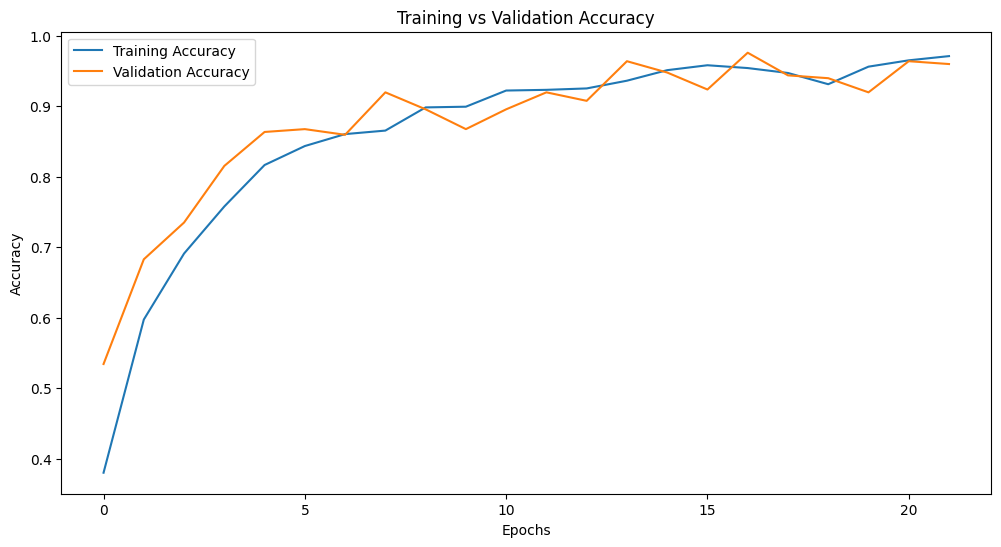

In [ ]:
# Plot accuracy and loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

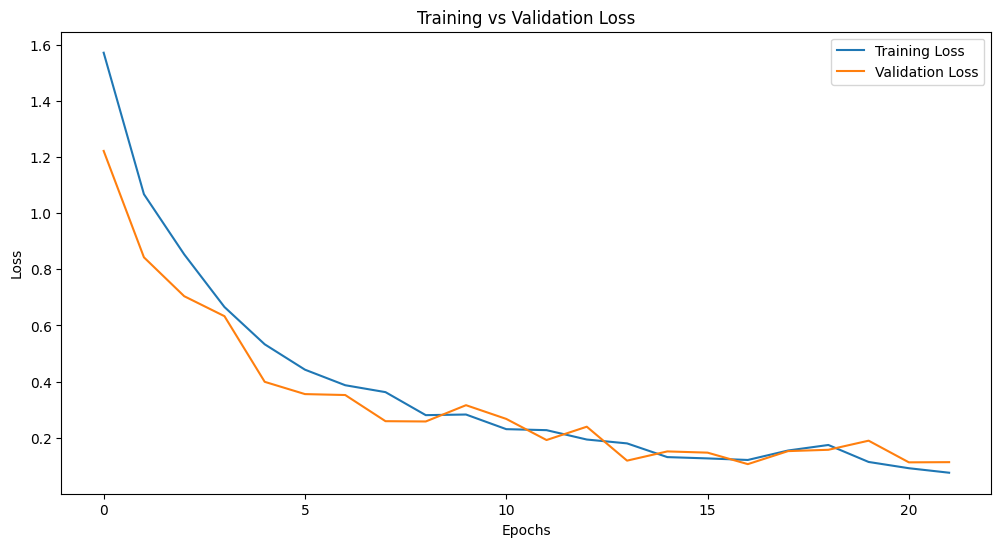

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_acc}")

# Save the final model
model.save('/content/drive/My Drive/final_defect_detection_model.h5')
print("Model saved successfully.")

8/8 ━━━━━━━━━━━━━━━━━━━━ 146s 18s/step - accuracy: 0.9594 - loss: 0.1481


Validation Loss: 0.11506393551826477
Validation Accuracy: 0.9678714871406555
Model saved successfully.


In [ ]:
lo